In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 11 14:11:45 2018

@author: doorleyr



"""

from collections import OrderedDict    
import pandas as pd                   
import numpy as np  
import pickle
#import pylogit as pl
import pyproj
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import graphviz
from IPython.display import Image
import pydotplus
import math
import matplotlib.pyplot as plt 




In [2]:
def getProfiles(clf, feature_names):
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold 
    props=clf.tree_.value
    visited=np.zeros(n_nodes)
    node=0
    parents={}
    profiles={}
    conditions=[]
    while sum(visited)<n_nodes:
        visited[node]=1
        print(node)
        if children_left[node]>0: #we are at a decision node
            #add the left condition
            if visited[children_left[node]]==0:
                conditions.append(str(feature_names[feature[node]]) + '<= '+ str(threshold[node]))
                #note the parent of the left child (this node) and move to the left node
                parents[children_left[node]]=node
                node=children_left[node]
            elif visited[children_right[node]]==0:
                conditions.append(str(feature_names[feature[node]]) + '>= '+ str(threshold[node]))            
                # note the parent of the right child (this node) and move to the right node
                parents[children_right[node]]=node
                node=children_right[node] 
            else:
                node=parents[node]
                conditions=conditions[:-1]
        else: #we are at a leaf node
            # save the class
            profiles[len(profiles)]={'conditions':conditions.copy(), 'prob': [props[node][0][p]/sum(props[node][0]) for p in range(len(props[node][0]))]}
            # go back to the parent of this node and remove the last condition
            node=parents[node]
            conditions=conditions[:-1]
            # add the right condition
    return profiles
        
pumasIncluded=['00507', '03306', '03304',
               '02800', '00506', '03305',
               '00704', '03603', '03400', 
               '03302', '03301', '00505',
               '03303', '00508']

def simpleMode(mode):
    # maps from the 12 mode categories in PUMS to a simpler categorisation
    if mode in [1,7,8]:
        return 0
    if mode ==9:
        return 1
    if mode ==10:
        return 2
    if mode ==11:
        return 4
    else:
        return 3



In [3]:
#get the individual and household data
indiv=pd.read_csv('./data/PUMS/csv_pma/ss16pma.csv')
hh=pd.read_csv('./data/PUMS/csv_hma/ss16hma.csv')
# look up the HH income for each individual
#indiv=indiv.merge(hh[[ 'GRNTP', 'VEH', 'TEN', 'HHT']], left_index=True, right_index=True, how='left')
indiv=indiv.merge(hh[[ 'GRNTP', 'VEH', 'TEN', 'HHT', 'SERIALNO']], on='SERIALNO', how='left')


colsToKeep={ 'PUMA':'homePUMA', 'POWPUMA':'workPOWPUMA', 'AGEP':'age',  'CIT':'citizen_status', 'MAR':'marraige_status','TEN':'Tenure', 'HHT': 'Household_type',
            'COW':'class_worker','MIG':'migration_status', 'SCH':'school_status', 'SCHL':'school_level', 'WAOB':'world_area_birth',
            'JWTR':'mode',  'JWAP':'arrivalT',  
#            'VEH': 'numCarsP', 
            'PINCP':'incomePersonal', 'SEX':'sex'}
indivWide=indiv[[c for c in colsToKeep]]
indivWide.columns=[colsToKeep[c] for c in colsToKeep]

indivWide['homePUMA']=indivWide.apply(lambda row: str(int(row['homePUMA']+1e10))[-5:], axis=1)
# convert PUMAs to strings of length 5 (with zeros at start)

#only keep records where puma is in the included zone (roughly GBA)
indivWideGBA=indivWide.loc[indivWide['homePUMA'].isin(pumasIncluded)].copy()

indivWorkWide=indivWideGBA[indivWideGBA['workPOWPUMA']>1].copy() # only keep people in the work force
#indivWorkWide['CA']=indivWorkWide['numCarsP']>0 #create binary for Cars Available


#indivWorkWide['homePUMA']=indivWorkWide.apply(lambda row: int(row['homePUMA']), axis=1)
#indivWorkWide['workPOWPUMA']=indivWorkWide.apply(lambda row: int(row['workPOWPUMA']), axis=1)
#
indivWorkWide['simpleMode']=indivWorkWide.apply(lambda row: simpleMode(row['mode']), axis=1)
indivCommute=indivWorkWide.loc[indivWorkWide['simpleMode']<4].reset_index(drop=True)
indivCommute=indivCommute.dropna(how='any')

#vars for bachelors and masters level edu
indivCommute['collegeDegree']=indivCommute.apply(lambda row: row['school_level']>20, axis=1)
indivCommute['gradDegree']=indivCommute.apply(lambda row: row['school_level']>21, axis=1)

catVars=['Tenure', 'Household_type', 'citizen_status', 'class_worker', 'marraige_status', 'migration_status', 'school_status', 'world_area_birth', 'sex']

for col in catVars:
    indivCommute=pd.concat([indivCommute, pd.get_dummies(indivCommute[col], prefix=col)],  axis=1) 
indivCommute=indivCommute.drop(catVars, axis=1)
indivCommute=indivCommute.drop(['homePUMA', 'workPOWPUMA', 'mode', 'school_level', 'sex_1'], axis=1)


#rename some important variables:
indivCommute=indivCommute.rename(columns={'Tenure_3.0':'Renter', 'sex_2':'female', 'class_worker_2.0': 'non-profit_worker', 'Household_type_6.0': '1PersonFemaleHH'})

features=indivCommute.drop(['simpleMode'], axis=1)



/Users/doorleyr/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
l=5
clf = tree.DecisionTreeClassifier(max_leaf_nodes=l, class_weight='balanced')            
clf = clf.fit(np.array(features), np.array(indivCommute['simpleMode'])) 
dot_data = tree.export_graphviz(clf, out_file='treeBalanced' +str(l)+'.dot',feature_names=features.columns,  
                         class_names=['drive', 'cycle', 'walk', 'PT'],  
                         filled=True, rounded=True,  
                         special_characters=True) 
with open('treeBalanced' +str(l)+'.dot') as f:
   dot_graph = f.read()
g=graphviz.Source(dot_graph)
g.render(filename='treeBalanced' +str(l))

profiles=getProfiles(clf, features.columns)



0
1
3
1
4
1
0
2
5
2
6
7
6
8


In [5]:
%matplotlib inline

([<matplotlib.axis.XTick at 0x11e7a5828>,
 <a list of 49 Text xticklabel objects>)

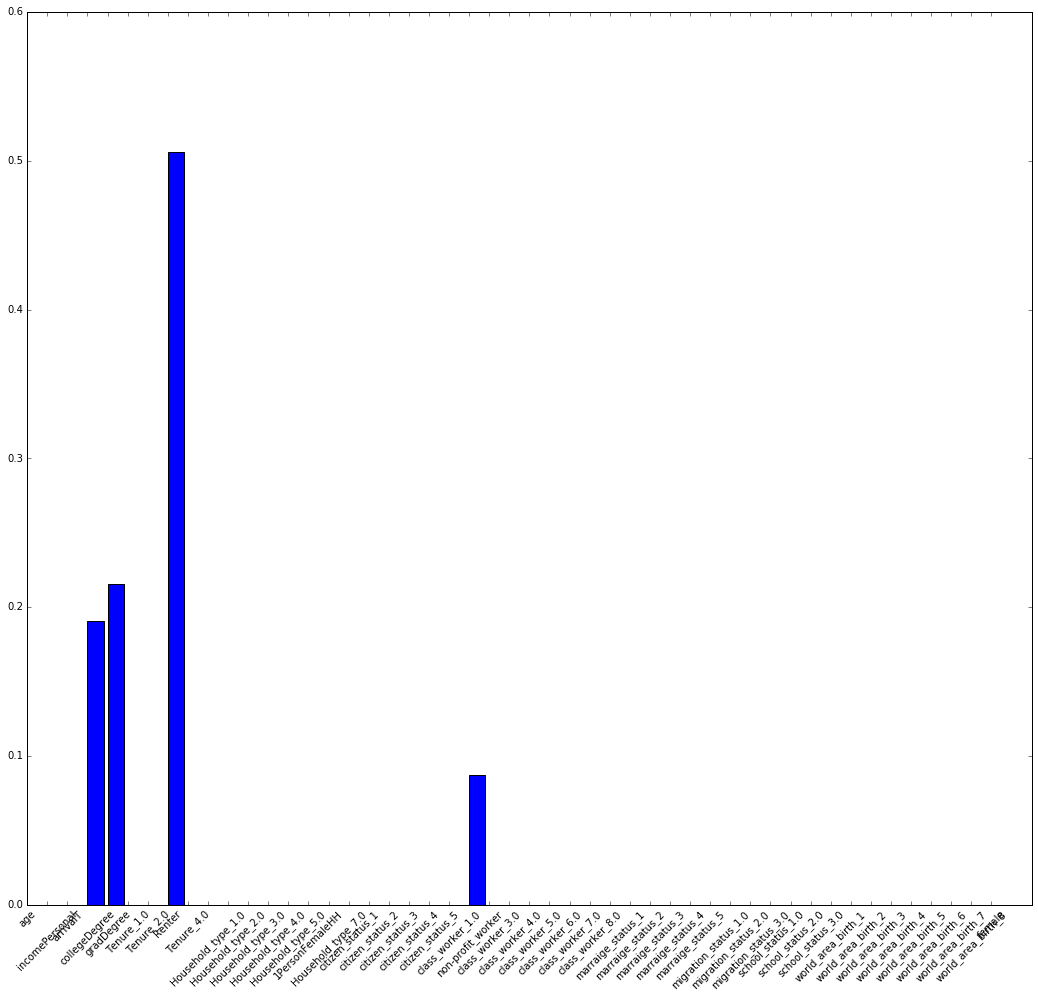

In [6]:
#for name, importance in zip(features.columns, clf.feature_importances_):
#    print(name, importance)

plt.figure(figsize=(18, 16))    
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.xticks(range(len(clf.feature_importances_)), features.columns, rotation=45)

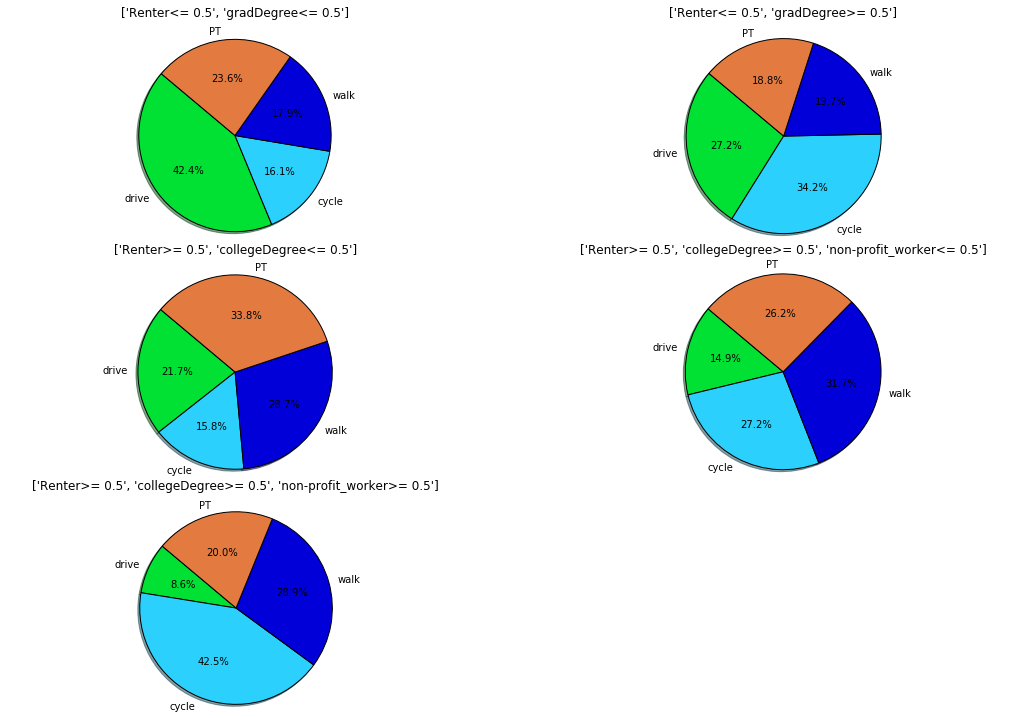

In [7]:
# plot the profiles

# Data to plot
labels = ['drive', 'cycle', 'walk', 'PT']
cols=2
rows=math.ceil(len(profiles)/cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6*rows, 6*cols))
for p in profiles: 
    row=p//2
    column=p%2      
    sizes = profiles[p]['prob']
    colors = [[0, 225/255, 51/255], [43/255, 209/255, 252/255], [25/2555, 0/255, 217/255], [227/255, 123/255, 64/255]]
    # explode = (0.1, 0, 0, 0)  # explode 1st slice
    # Plot
    axes[row,column].pie(sizes, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)
    axes[row,column].axis('equal')
    axes[row,column].set_title(profiles[p]['conditions'], y=1.08)
#delete unused axes
for a in range(p%2+1, 2):
    fig.delaxes(axes[rows-1][a])
plt.show()

